# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight == 0.1.2

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'galight_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


        Use `~photutils.segmentation.SourceCatalog` instead. [galight.tools.measure_tools]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


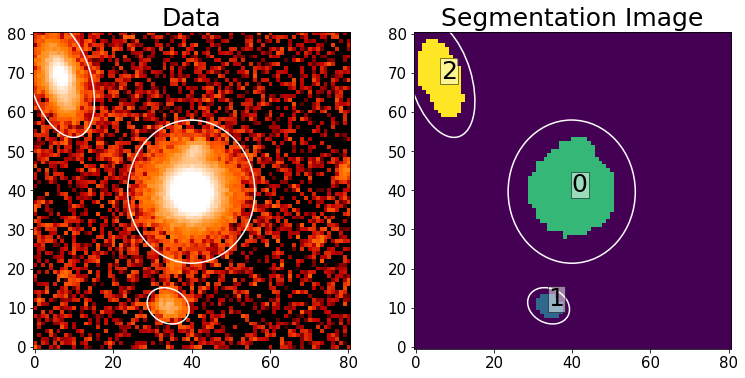

 id xcentroid ycentroid     source_sum        orientation      area
       pix       pix                              deg          pix2
--- --------- --------- ------------------ ------------------ -----
  1     33.97     10.48 14.885032821358399 -26.91718948216723  34.0
  0     39.88     39.65  947.0203578785317 -89.36988288870309 415.0
  2      6.44     68.57 135.44832862678643 -73.06587332740483 169.0
Input directly the a obj that used to create MASK, use space between each id:
1


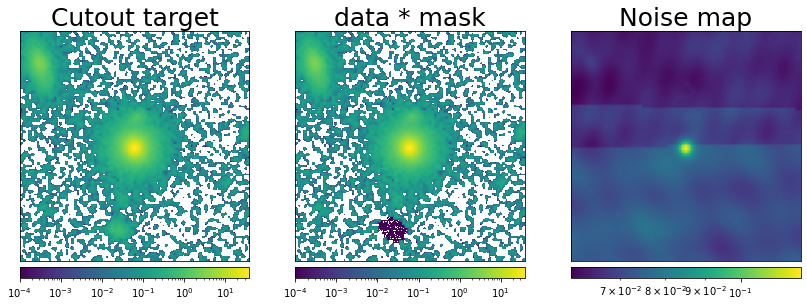

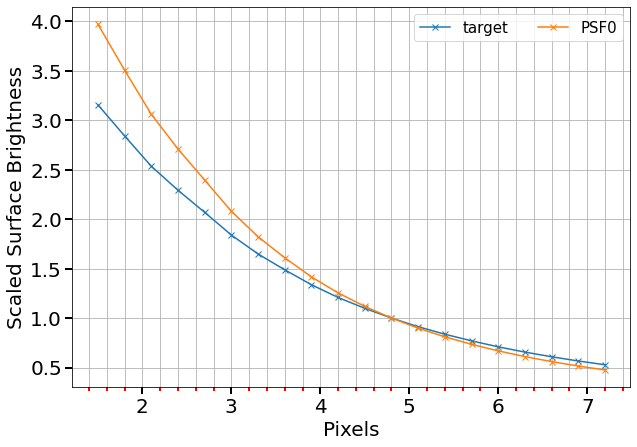

The PSF is not a box size, will cut it to a box size automatically.
The data_process is ready to go to pass to FittingSpecify!


In [2]:
from galight.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=None, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


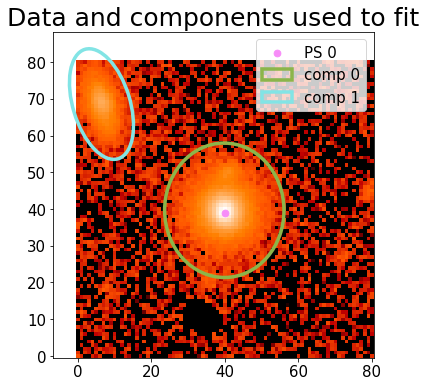

In [3]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook galight_HST_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.928209720019578 reduced X^2 of best position
-6232.937919963286 logL
6465.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.752457086027014, 'n_sersic': 8.908792216092312, 'e1': -0.07326128698944759, 'e2': 0.058349345480278154, 'center_x': 0.09384065145758004, 'center_y': -0.04849533682441905}, {'amp': 1, 'R_sersic': 2.3077158130418307, 'n_sersic': 8.449332735125006, 'e1': -0.42618481245662654, 'e2': 0.2576232843268135, 'center_x': 5.640220155529509, 'center_y': 4.914167855318024}] lens light result
[{'ra_image': array([0.00445377]), 'dec_image': array([-0.1317452]), 'point_amp': array([1.])}] point source result
{} special param result
12.845338106155396 time used for  PSO
[-1.42746914 -1.34814898 -0.66445637 -1.30683078 -1.59007768  1.06718256
 -0.84456709  1.62702512  0.0679445   0.17083326  0.23833677  0.77626392
  0.10966256  1.36167573] test


100%|█████████████████████████████████████████████████| 130/130 [01:38<00:00,  1.32it/s]


Computing the MCMC...
Number of walkers =  140
Burn-in iterations:  100
Sampling iterations (in current run): 130
99.30035138130188 time taken for MCMC sampling
112.581 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
4200 MCMC samplers in total, finished translate: 1000
4200 MCMC samplers in total, finished translate: 2000
4200 MCMC samplers in total, finished translate: 3000
4200 MCMC samplers in total, finished translate: 4000


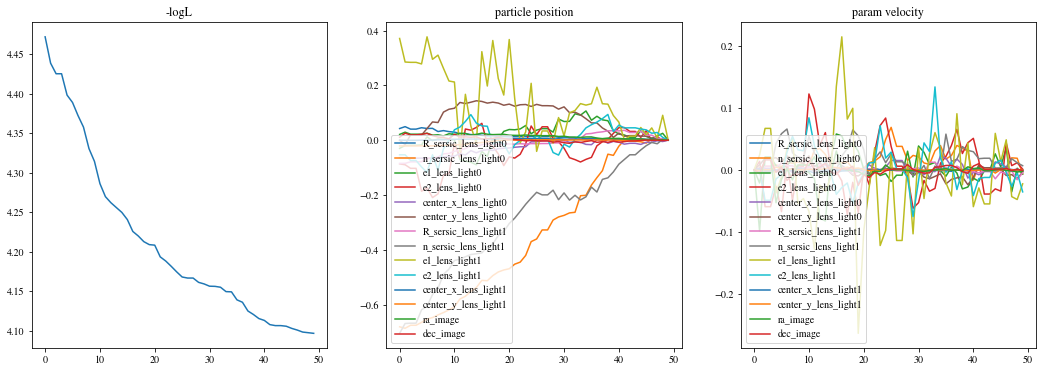

<Figure size 432x288 with 0 Axes>

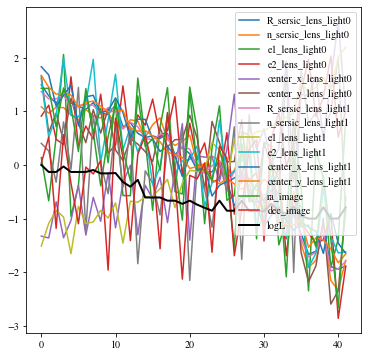

-1.8644644011288973 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.864464401128897


/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:89: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:124: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:522: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


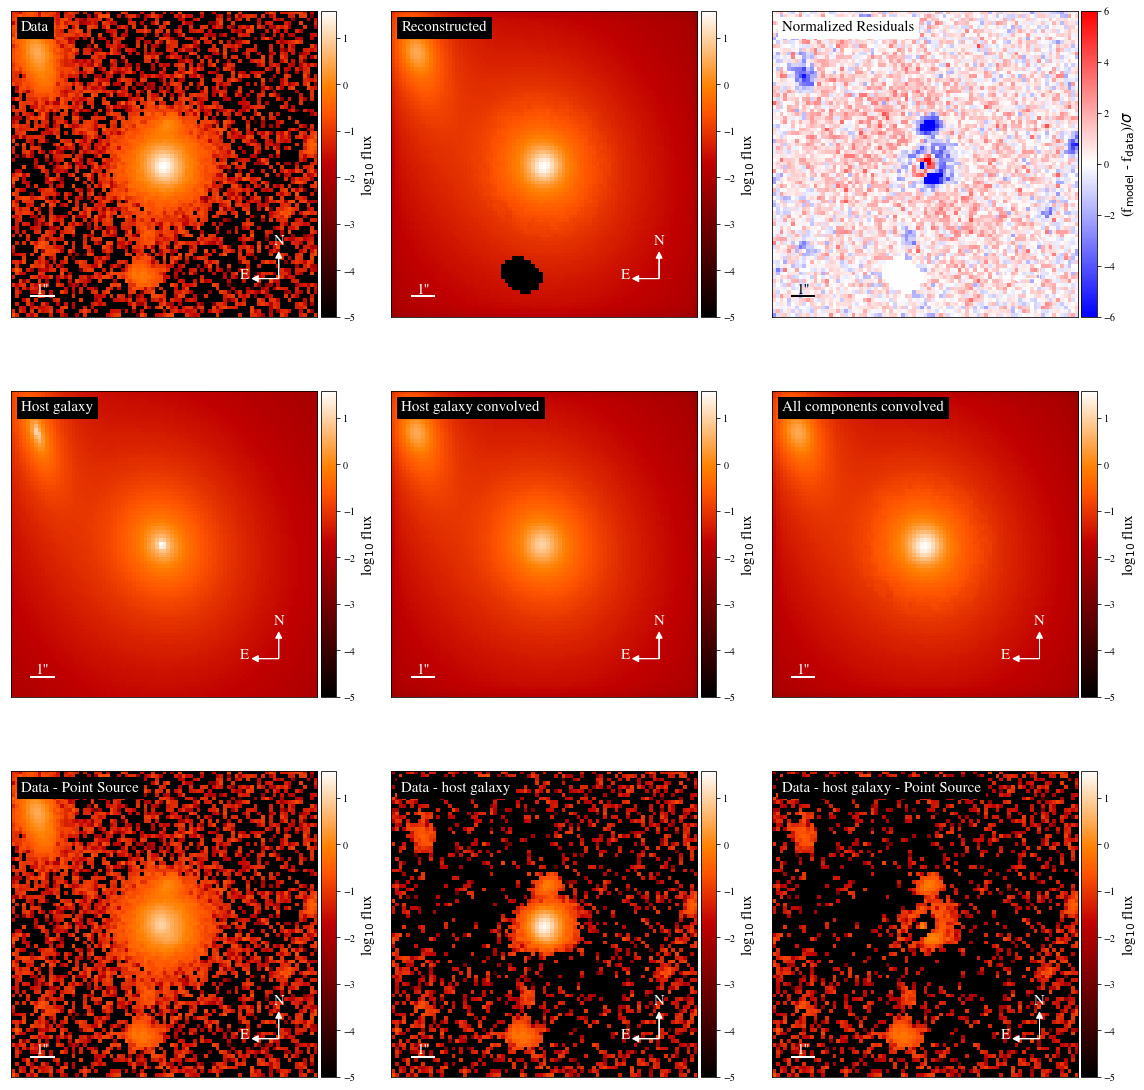

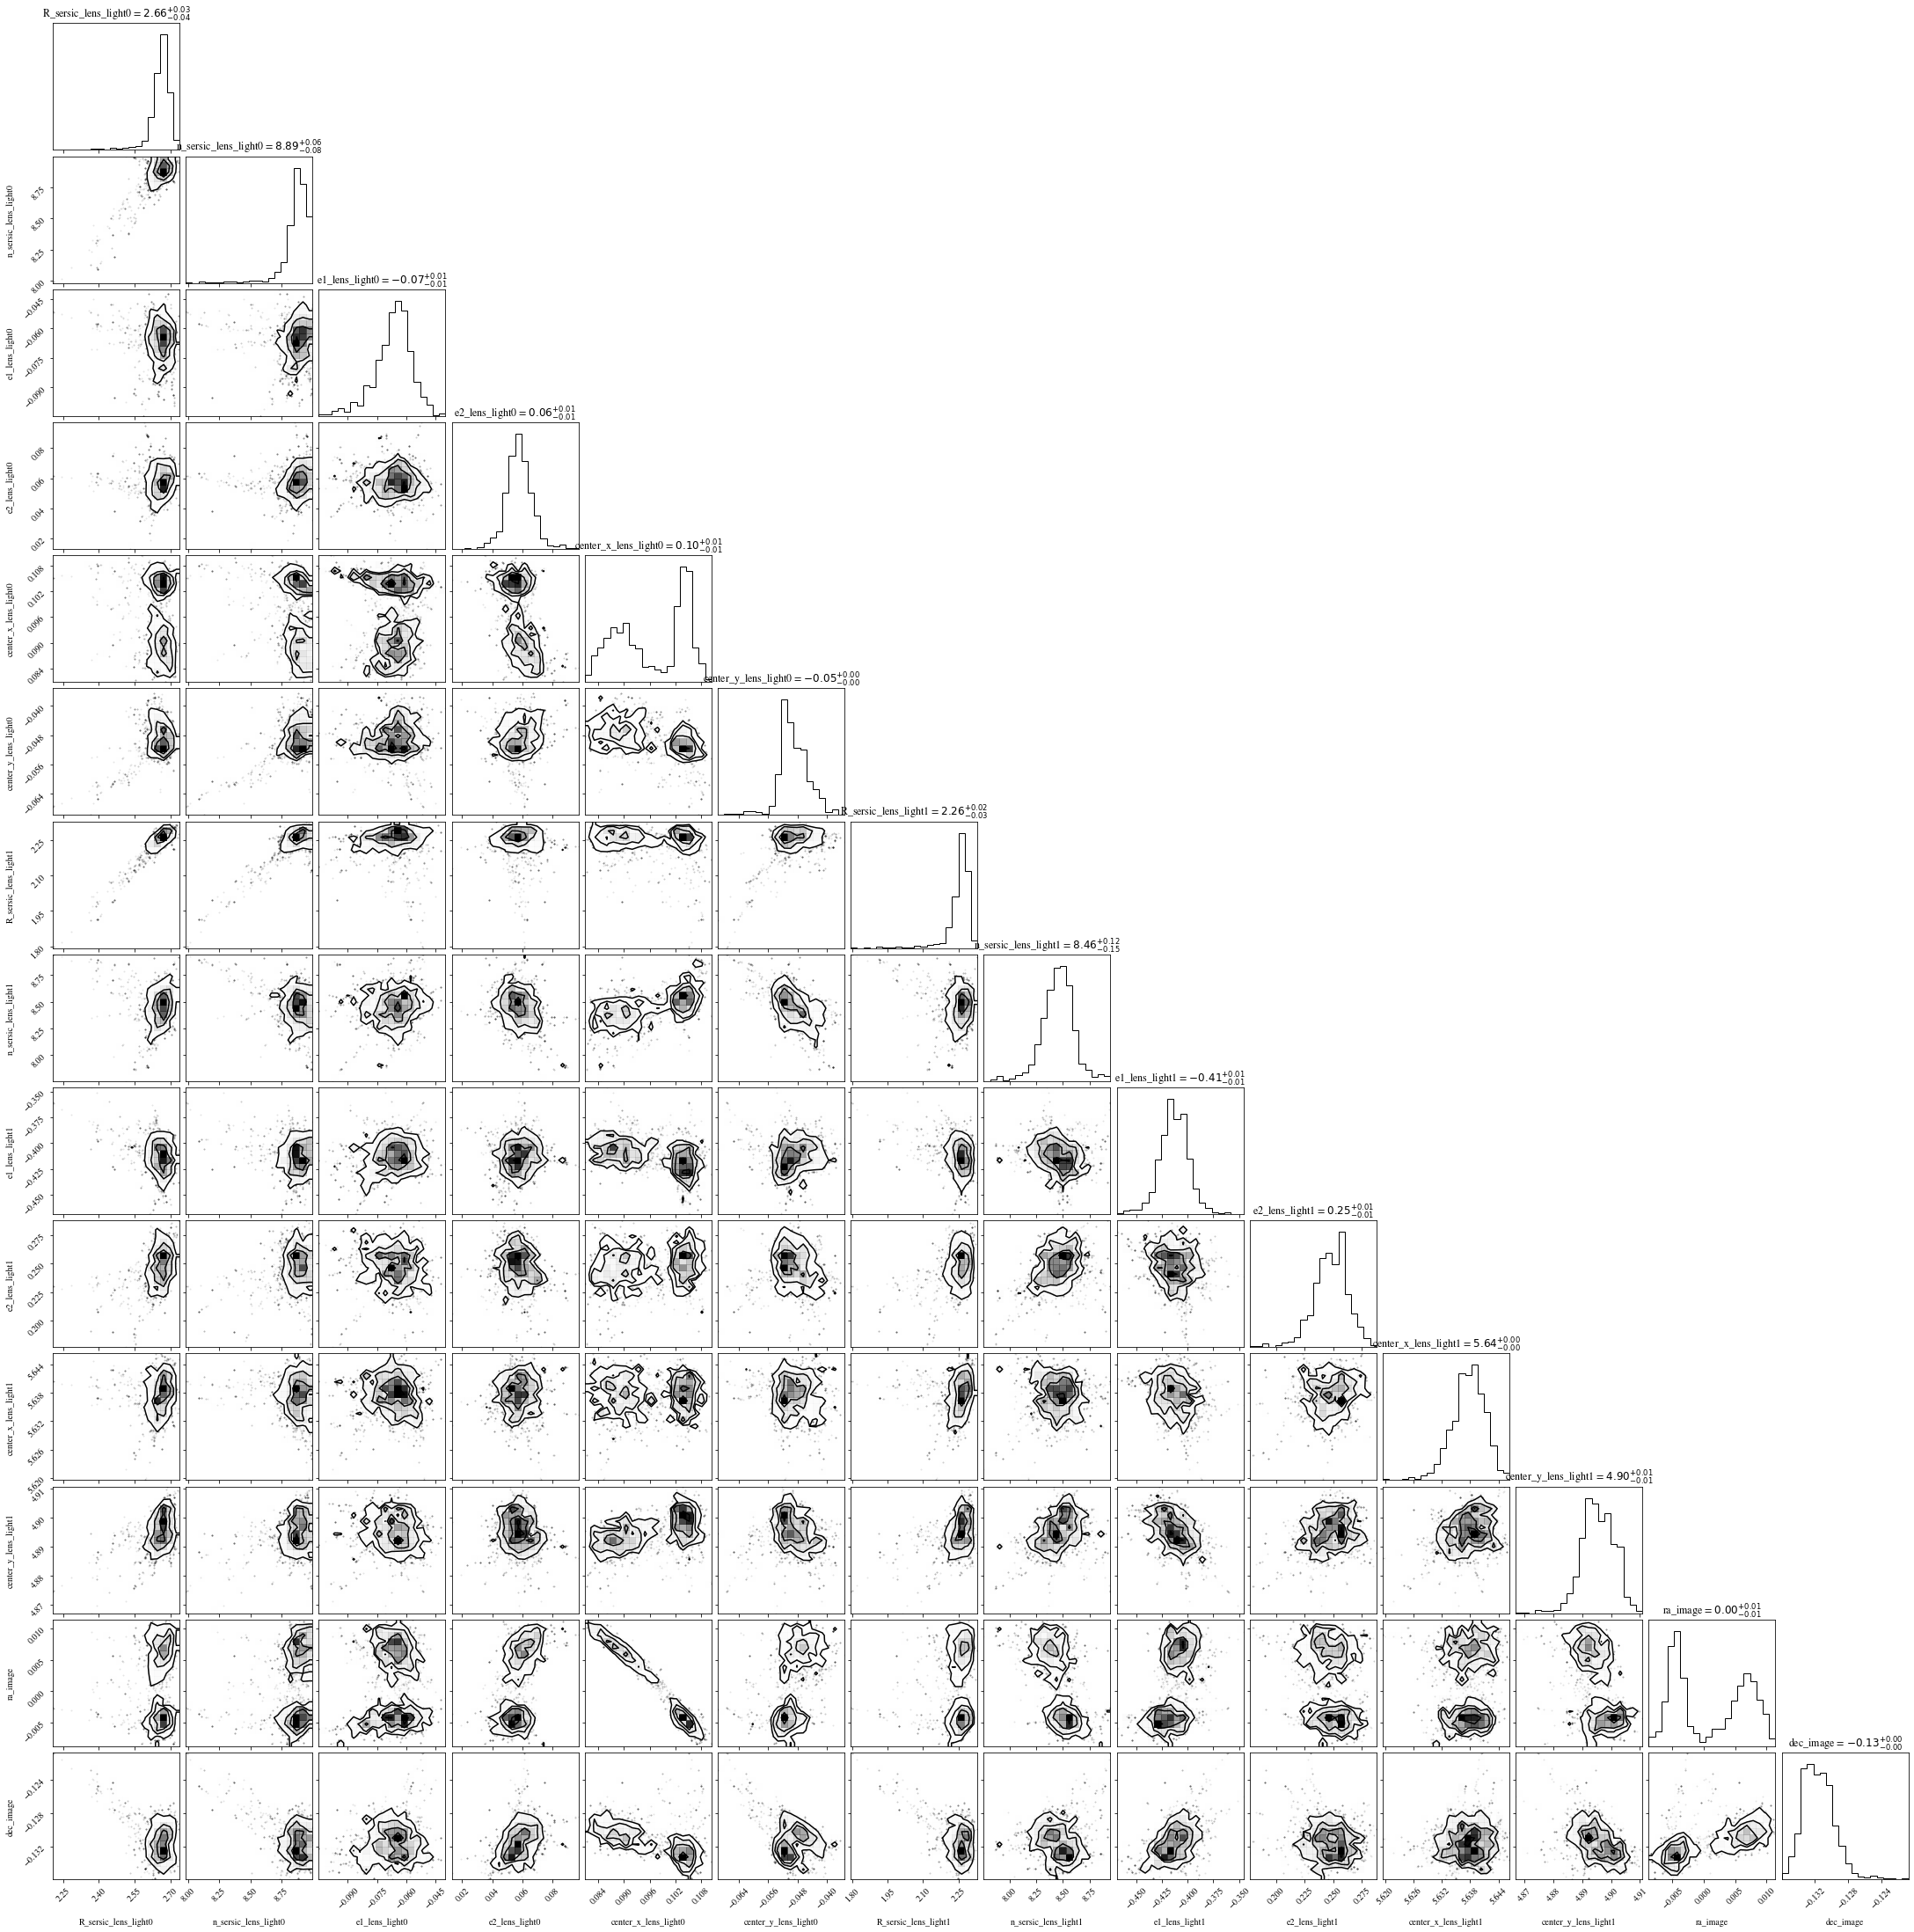

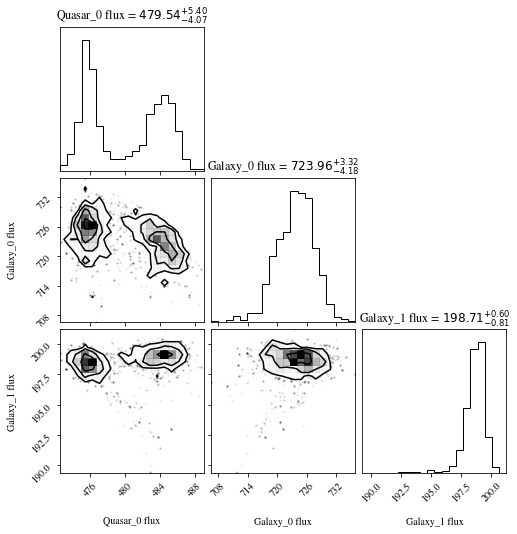

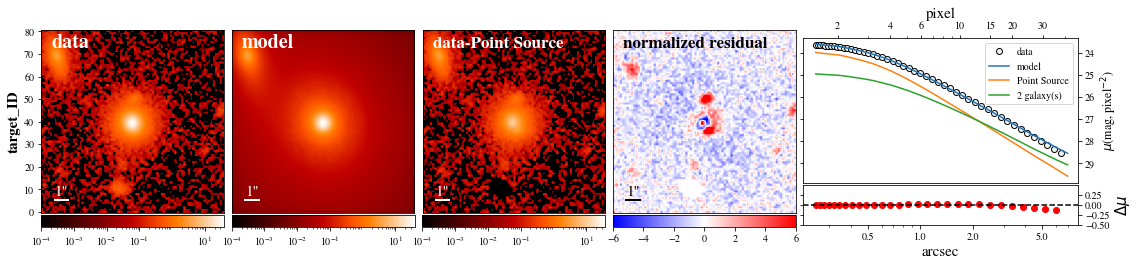

In [4]:
#Setting the fitting method and run.
from galight.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         input template: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         input template: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()


#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [5]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 6.346025849466967,
  'R_sersic': 2.387842001408994,
  'n_sersic': 8.307608415899598,
  'e1': -0.05750214841387642,
  'e2': 0.057470748985709134,
  'center_x': 0.10507164894426685,
  'center_y': -0.06075612696991804,
  'phi_G': 1.178233796527409,
  'q': 0.8496286693750286,
  'flux_sersic_model': 1171.2760957642117,
  'flux_within_frame': 716.7118337352854,
  'magnitude': 19.861638561926796},
 {'amp': 6.81669909439733,
  'R_sersic': 1.9710714222490167,
  'n_sersic': 8.798626432892945,
  'e1': -0.38887559862991666,
  'e2': 0.23790738250126683,
  'center_x': 5.6395636992115135,
  'center_y': 4.88443027090451,
  'phi_G': 1.2962771924899275,
  'q': 0.3737420989524612,
  'flux_sersic_model': 881.846365967333,
  'flux_within_frame': 193.04026419719395,
  'magnitude': 21.285880241795716}]